# Compare DiffractIO / TemGym, Single Gaussian Beam

In [85]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib ipympl

In [86]:
def FresnelPropagator(E0, ps, lambda0, z):
    """
    Parameters:
        E0 : 2D array
            The initial complex field in the x-y source plane.
        ps : float
            Pixel size in the object plane (same units as wavelength).
        lambda0 : float
            Wavelength of the light (in the same units as ps).
        z : float
            Propagation distance (in the same units as ps).

    Returns:
        Ef : 2D array
            The complex field after propagating a distance z.
    """
    n, m = E0.shape

    fx = np.fft.fftfreq(n, ps)
    fy = np.fft.fftfreq(m, ps)
    Fx, Fy = np.meshgrid(fx, fy)

    H = (
        np.exp(-1j * (2 * np.pi / lambda0) * z)
        * np.exp(-1j * np.pi * lambda0 * z * (Fx**2 + Fy**2))
    )
    E0fft = np.fft.fft2(E0)
    G = H * E0fft
    Ef = np.fft.ifft2(G)

    return Ef


def lens_phase_factor(n, ps, lambda0, f):
    """
    Compute the phase factor introduced by an ideal lens.
    
    Parameters:
        n : int
            Number of pixels (assuming square grid, n x n).
        ps : float
            Pixel size (in the same units as wavelength and focal length).
        lambda0 : float
            Wavelength of the light (in the same units as ps).
        f : float
            focal length of the lens (in the same units as ps).
    
    Returns:
        phase_factor : 2D array (n x n)
            The phase factor to multiply with the field.
    """
    x = np.linspace(-n/2, n/2 - 1, n) * ps
    y = np.linspace(-n/2, n/2 - 1, n) * ps
    X, Y = np.meshgrid(x, y)
    
    phase_factor = np.exp(-1j * np.pi * (X**2 + Y**2) / (lambda0 * f) + 1j * np.pi)
    
    return phase_factor

## Parameters

In [87]:
n_rays = 1
wavelength = 0.01
wo = 0.1
prop_dist = 25

# If focal is a float, place a lens at lens_dist_fraction * prop_dist
# If focal is None, don't use a lens
focal = np.random.uniform(4.0, 20)
lens_dist_fraction = 0.5

x0 = np.random.uniform(-1, 1)
y0 = np.random.uniform(-1, 1)
theta_x = np.random.uniform(-2, 2)
theta_y = np.random.uniform(-2, 2)

# Detector params
size = 2048
det_shape = (size, size)
pixel_size = 0.01
dsize = det_shape[0] * pixel_size

k = 2 * np.pi / wavelength
deg_yx = np.deg2rad((theta_y, theta_x))
tilt_yx = np.tan(deg_yx)

# Calculate theta and phi
tan_theta_x = np.tan(deg_yx[1])
tan_theta_y = np.tan(deg_yx[0])
theta = np.arctan(np.sqrt(tan_theta_x**2 + tan_theta_y**2))
phi = np.arctan2(tan_theta_y, tan_theta_x)


## DiffractIO

In [88]:
from diffractio.scalar_sources_XY import Scalar_source_XY

In [89]:
x_det = np.linspace(-dsize / 2, dsize / 2, size)
fresnel_input_field = Scalar_source_XY(x=x_det, y=x_det, wavelength=wavelength)
fresnel_input_field.gauss_beam(A=1, r0=(x0, y0), z0=0, w0=(wo, wo), theta=theta, phi=phi)
if focal is not None:
    fresnel_output_field = FresnelPropagator(fresnel_input_field.u, pixel_size, wavelength, prop_dist * lens_dist_fraction)
    fresnel_output_field = fresnel_output_field * lens_phase_factor(size, pixel_size, wavelength, focal)
    fresnel_output_field = FresnelPropagator(fresnel_output_field, pixel_size, wavelength, prop_dist * (1 - lens_dist_fraction))
else:
    fresnel_output_field = FresnelPropagator(fresnel_input_field.u, pixel_size, wavelength, prop_dist)

## TemGym

In [90]:
from temgymbasic.model import (
    Model,
)
from temgymbasic import components as comp
from temgymbasic.utils import calculate_phi_0

In [91]:
components = (
    comp.GaussBeam(
        z=0.0,
        voltage=calculate_phi_0(wavelength),
        radius=x0,
        wo=wo,
        tilt_yx=tilt_yx
    ),
    comp.AccumulatingDetector(
        z = prop_dist,
        pixel_size=pixel_size,
        shape=det_shape,
        buffer_length=1,
    ),
)

if focal is not None:
    components = (
        components[0],
        comp.Lens(
            z = prop_dist * lens_dist_fraction,
            f = focal,
        ),
        components[1],
    )

components[0].set_centre((y0, x0))

model = Model(components)
rays = tuple(model.run_iter(num_rays=n_rays, random = False))
temgym_image = model.detector.get_image(rays[-1])

## Comparisons

First find the position of the max amplitude in the Fresnel image to serve as a reference point for profiles etc.:

In [92]:
maxidx = np.argmax(np.abs(fresnel_output_field).ravel())
sy, sx = fresnel_output_field.shape
max_y, max_x = size//2, size//2 #np.unravel_index(maxidx, (sy, sx))
ver_slice = np.s_[:, max_x]
hor_slice = np.s_[max_y, :]

Match the phases at the position of max amplitude in the Fresnel image:

In [93]:
max_amp_phase = np.angle(fresnel_output_field[max_y, max_y])
temgym_eq_phase = np.angle(temgym_image[max_y, max_y])
phase_correction = max_amp_phase - temgym_eq_phase
temgym_image *= np.exp(1j * phase_correction)

In [94]:
title_stub = f"Theta x/y ({theta_x:.1f}, {theta_y:.1f}), Origin x/y ({x0:.1f}, {y0:.1f}), Focal: {focal:.1f}, PropDist: {prop_dist:.1f}"

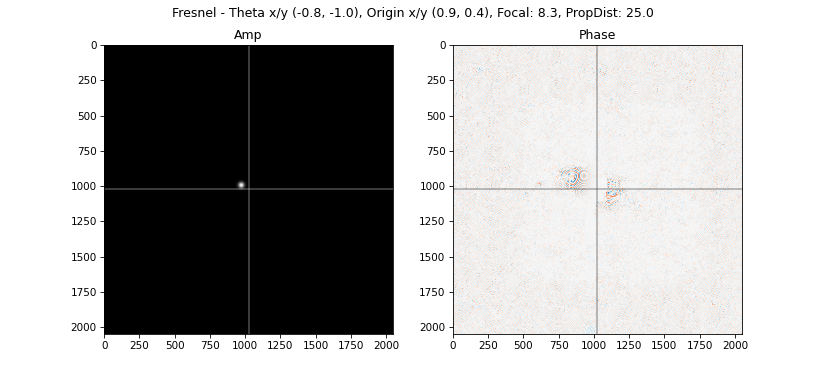

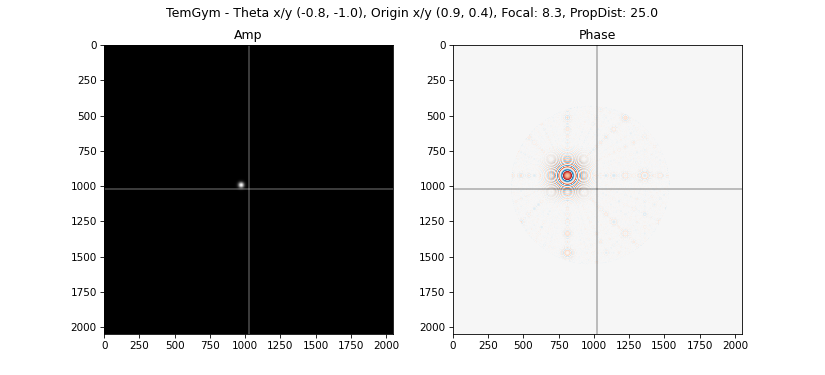

In [95]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5))
ax1.imshow(np.abs(fresnel_output_field), cmap='gray')
ax1.axvline(size // 2, color='white', alpha=0.3)
ax1.axhline(size // 2, color='white', alpha=0.3)
ax1.set_title("Amp")
ax2.imshow(np.angle(fresnel_output_field), cmap='RdBu')
ax2.axvline(size // 2, color='k', alpha=0.3)
ax2.axhline(size // 2, color='k', alpha=0.3)
ax2.set_title("Phase")
fig.suptitle(f"Fresnel - {title_stub}");

fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(11, 5))
ax3.imshow(np.abs(temgym_image), cmap='gray')
ax3.axvline(size // 2, color='white', alpha=0.3)
ax3.axhline(size // 2, color='white', alpha=0.3)
ax3.set_title("Amp")
ax4.imshow(np.angle(temgym_image), cmap='RdBu')
ax4.axvline(size // 2, color='k', alpha=0.3)
ax4.axhline(size // 2, color='k', alpha=0.3)
ax4.set_title("Phase")
fig.suptitle(f"TemGym - {title_stub}");

Plot a vertical slice through the max amplitude point

/tmp/ipykernel_3434129/1041133656.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))


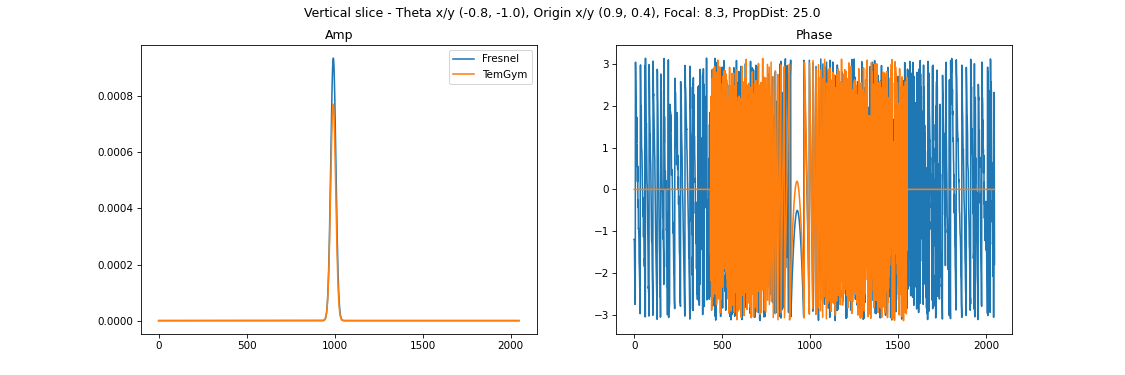

In [96]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(np.abs(fresnel_output_field)[ver_slice], label='Fresnel')
ax1.plot(np.abs(temgym_image)[ver_slice], label='TemGym')
ax1.set_title("Amp")
ax2.plot(np.angle(fresnel_output_field)[ver_slice], label='Fresnel')
ax2.plot(np.angle(temgym_image)[ver_slice], label='TemGym')
ax2.set_title("Phase")
fig.suptitle(f"Vertical slice - {title_stub}")
ax1.legend();